In [30]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost as xgb
from sklearn import svm
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    confusion_matrix,
)

In [31]:
sex= 'Female'
control = pd.read_csv(f"../result/Control_{sex}_snp.csv")
training = pd.read_csv(f"../result/Training_{sex}_snp.csv")

print(control.shape)
print(training.shape)

(2446, 213)
(1066, 213)


In [32]:
features = pd.concat([control,training],ignore_index=True)
features = features.drop(columns=['TWB2_ID','I_32','Label'])

#將ID排除
X = features.iloc[:,1::]
print(X.info())

feature_names = X.columns
X = [X.iloc[i,:].values.flatten().tolist() for i in range(control.shape[0]+training.shape[0])]
print('樣本數: ',len(X))

control_label=control.iloc[:,-1]
training_label=training.iloc[:,-1]
y=pd.concat([control_label,training_label],ignore_index=True)
label_encoder = LabelEncoder()
y = list(label_encoder.fit_transform(y))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Columns: 209 entries, AGE to MICROALB
dtypes: float64(162), int64(47)
memory usage: 5.6 MB
None
樣本數:  3512


In [33]:
from collections import Counter

# 分割資料集 (training and validation sets)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"訓練集樣本數量： {len(X_train)}")
print(f"測試集樣本數量： {len(X_val)}")
train_class_distribution = Counter(y_train)
val_class_distribution = Counter(y_val)
print("訓練集中各類別樣本數量：")
print(train_class_distribution)
print("測試集中各類別樣本數量：")
print(val_class_distribution)

訓練集樣本數量： 3160
測試集樣本數量： 352
訓練集中各類別樣本數量：
Counter({0: 2192, 1: 968})
測試集中各類別樣本數量：
Counter({0: 254, 1: 98})


In [34]:
# SMOTE
# train set use SMOTE
smote_train_X, smote_train_Y = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("SMOTE train set sampling:")
print(Counter(smote_train_Y))

# train set use BSMOTE
bsmote_train_X, bsmote_train_Y = BorderlineSMOTE(
    random_state=42, kind="borderline-2"
).fit_resample(X_train, y_train)
print("BSMOTE train set sampling:")
print(Counter(bsmote_train_Y))

# test set balance
bal_x_test, bal_y_test = RandomUnderSampler(random_state=42).fit_resample(X_val, y_val)
print("Random sampling:")
print(Counter(bal_y_test))

smote_test_X, smote_test_Y = SMOTE(random_state=42).fit_resample(X_val, y_val)
print("SMOTE test set sampling:")
print(Counter(smote_test_Y))

bsmote_test_X, bsmote_test_Y = BorderlineSMOTE(random_state=42).fit_resample(X_val, y_val)
print("BSMOTE test set sampling:")
print(Counter(bsmote_test_Y))

SMOTE train set sampling:
Counter({0: 2192, 1: 2192})
BSMOTE train set sampling:
Counter({0: 2192, 1: 2192})
Random sampling:
Counter({0: 98, 1: 98})
SMOTE test set sampling:
Counter({0: 254, 1: 254})
BSMOTE test set sampling:
Counter({0: 254, 1: 254})


In [35]:
# Male
# selected_rs = features.iloc[:,113:113+47].columns.tolist()

# Female
selected_rs = features.iloc[:,121:121+47].columns.tolist()

print(selected_rs)
indices = [feature_names.get_loc(feature) for feature in selected_rs]
print("feature num:", len(indices))

smote_train_X = [[row[i] for i in indices] for row in smote_train_X]
smote_test_X = [[row[i] for i in indices] for row in smote_test_X]
bsmote_test_X = [[row[i] for i in indices] for row in bsmote_test_X]

['rs74315294', 'rs80356605', 'rs199766465', 'rs397515598', 'rs752043324', 'rs1805124', 'rs751538672', 'rs11934801', 'rs369107336', 'rs192654796', 'rs969485098', 'rs144286892', 'rs775633137', 'rs121912910', 'rs111033313', 'rs121908362', 'rs41307295', 'rs199472941', 'rs1060500661', 'rs193066451', 'rs515726199', 'rs515726186', 'rs745750156', 'rs776825296', 'rs2228527', 'rs747453876', 'rs199473471', 'rs62645916', 'rs146689036', 'rs34946266', 'rs773528125', 'rs111033204', 'rs80338943', 'rs28942074', 'rs755377592', 'rs312262709', 'rs146682486', 'rs2020959', 'rs63750402', 'rs747175448', 'rs766187994', 'rs1267868260', 'rs724159978', 'rs1140458', 'rs75949023', 'rs121909104', 'rs201118034']
feature num: 47


In [36]:
def set_parameters(model, param_grid):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(smote_train_X, smote_train_Y)
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)
    return grid_search.best_estimator_

#xgb
param_xgb = {
    # Male
    # 'learning_rate': [0.01,0.05, 0.1],
    # 'n_estimators': [100,200,300],
    # 'max_depth': [2,3, 4],
    # 'subsample': [0.6,0.7,0.8],
    # 'colsample_bytree': [0.2,0.3,0.4],
    # 'min_child_weight': [20,30,40]
    # Female
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100,200,300],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.2,0.3,0.4]
}
xgb_model = set_parameters(xgb.XGBClassifier(random_state=42), param_xgb)

# rf
param_rf = {
    # Male
    # 'n_estimators': [100,200,300,400],
    # 'min_samples_split': [60,70,80,90],

    # Female
    'n_estimators': [100,150,200],
    'min_samples_split': [40,50,60],
    'min_samples_leaf': [40,50,60],
}
rf_model = set_parameters(
    ensemble.RandomForestClassifier(random_state=42), param_rf
)

# dt
param_dt = {
    # Male
    # 'max_depth': [5,6,7,8]

    # Female
    'max_depth': [6,7,8,9,10],
    'max_features': [30,35,40]
}
dt_model = set_parameters(DecisionTreeClassifier(random_state=42), param_dt)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best Score: 0.7505011376475427
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'min_samples_leaf': 40, 'min_samples_split': 40, 'n_estimators': 200}
Best Score: 0.6745323149175011
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'max_depth': 9, 'max_features': 35}
Best Score: 0.7085193400082265


In [24]:
def plot_confusion_matrix(confusion):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=[False, True])
    cm_display.plot()
    plt.show()

def evalution_metrics(test_label, labels_score, txt_name, save=True, path="../result/"):
    accuracy = accuracy_score(test_label, labels_score.round())
    confusion = confusion_matrix(test_label, labels_score.round())

    # plot confusion matrix
    plot_confusion_matrix(confusion)

    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    precision = TP / float(TP + FP)
    sensitivity = TP / float(FN + TP)
    specificity = TN / float(TN + FP)
    f1 = f1_score(test_label, labels_score.round())
    mcc = matthews_corrcoef(test_label, labels_score.round())

    metrics = np.round([TP, TN, FP, FN, accuracy, precision, sensitivity, specificity, f1, mcc], 2)
    columns = ["TP","TN","FP","FN","accuracy","precision","sensitivity","specificity","f1","mcc",]
    metrics_dict = dict(zip(columns, metrics))

    if save:
        df = pd.DataFrame(metrics_dict, index=[0])
        df.to_csv(path + "%s_metrics.csv" % txt_name)

        print("  # TP: %f" % TP + "\n")
        print("  # TN: %f" % TN + "\n")
        print("  # FP: %f" % FP + "\n")
        print("  # FN: %f" % FN + "\n")
        print("  # Accuracy: %f" % accuracy + "\n")
        print("  # Precision: %f" % precision + "\n")
        print("  # Sensitivity/Recall: %f" % sensitivity + "\n")
        print("  # Specificity: %f" % specificity + "\n")
        print("  # F1 score: %f" % f1 + "\n")
        print("  # Matthews Corrcoef:%f" % mcc + "\n")
    else:
        return metrics_dict

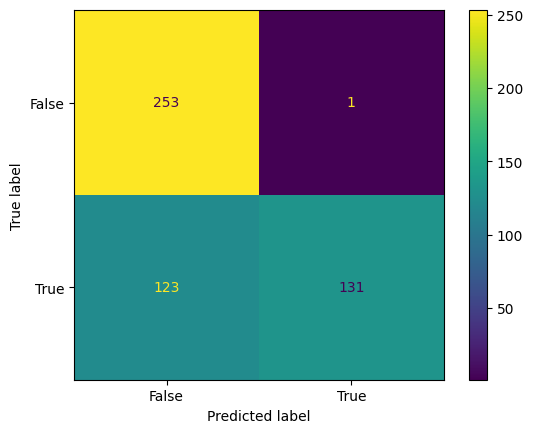

  # TP: 131.000000

  # TN: 253.000000

  # FP: 1.000000

  # FN: 123.000000

  # Accuracy: 0.755906

  # Precision: 0.992424

  # Sensitivity/Recall: 0.515748

  # Specificity: 0.996063

  # F1 score: 0.678756

  # Matthews Corrcoef:0.583529

Training Accuracy: 0.750228102189781


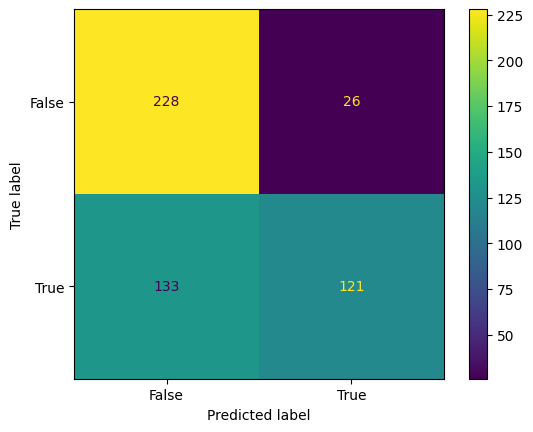

  # TP: 121.000000

  # TN: 228.000000

  # FP: 26.000000

  # FN: 133.000000

  # Accuracy: 0.687008

  # Precision: 0.823129

  # Sensitivity/Recall: 0.476378

  # Specificity: 0.897638

  # F1 score: 0.603491

  # Matthews Corrcoef:0.412393

Training Accuracy: 0.7071167883211679


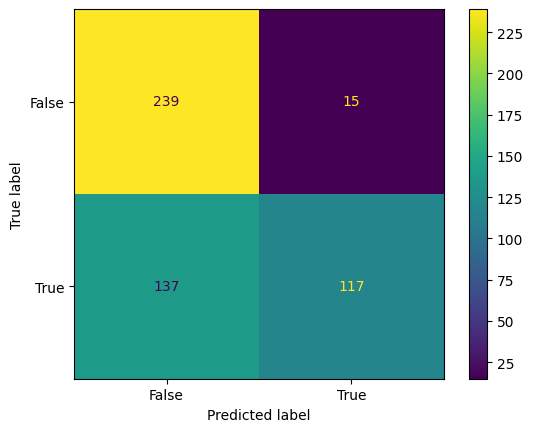

  # TP: 117.000000

  # TN: 239.000000

  # FP: 15.000000

  # FN: 137.000000

  # Accuracy: 0.700787

  # Precision: 0.886364

  # Sensitivity/Recall: 0.460630

  # Specificity: 0.940945

  # F1 score: 0.606218

  # Matthews Corrcoef:0.457846

Training Accuracy: 0.7363138686131386


In [37]:
models = {
    "XGBoost": xgb_model,
    "RandomForest": rf_model,
    "DecisionTree": dt_model,
}

for name, model in models.items():
    y_pred = model.predict(smote_test_X)
    evalution_metrics(smote_test_Y, y_pred, name)

    y_pred_train = model.predict(smote_train_X)
    print("Training Accuracy:",accuracy_score(smote_train_Y, y_pred_train.round()))

#### SHAP

In [38]:
import shap
shap.initjs()

In [41]:
explainer = shap.TreeExplainer(xgb_model)
smote_test_X = pd.DataFrame(smote_test_X, columns=selected_rs)
shap_values = explainer(smote_test_X)

print(f"length of SHAP values: {len(shap_values)}")
print(f"Shape of each element: {shap_values.shape}")

length of SHAP values: 508
Shape of each element: (508, 47)


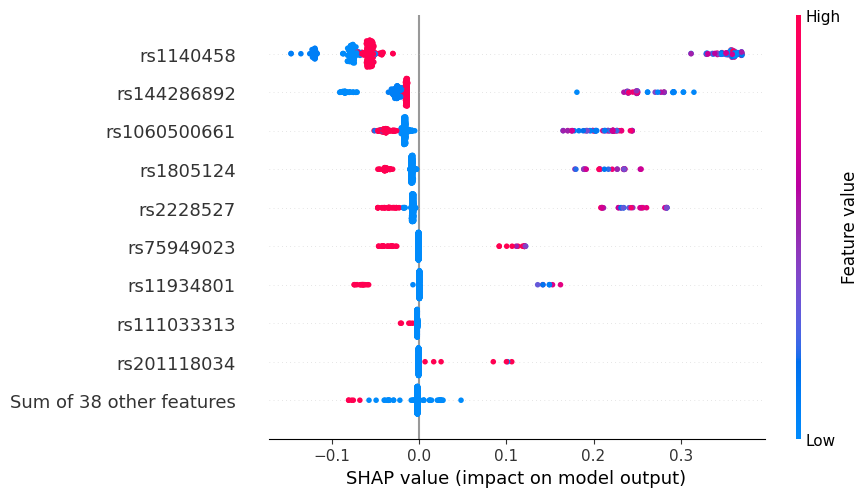

In [42]:
from shap.plots import colors

# shap.summary_plot(shap_values, smote_test_X, feature_names=feature_names)
# shap.summary_plot(shap_values[:, :, 1], smote_test_X, feature_names=selected_rs)  # 顯示第一個值（正向影響）

shap.plots.beeswarm(shap_values)